In [1]:
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc
import numpy as np
import stpsf
from stpsf import roman
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import os
import pandas as pd

In [2]:
'''
Code adapted from Eddie Schlafly 
'''


filts = ['f062','f087','f106','f129','f158','f184','f213']
wfi = roman.WFI()

# Lancaster+2022
ab_minus_vega = dict(f062=0.147,
                     f087=0.485,
                     f106=0.647,
                     f129=0.950,
                     f146=1.012,
                     f158=1.281,
                     f184=1.546,
                     f213=1.819)


def get_psf_report(filt, mag):
    """SNR from Pandeia.  Lots of stuff in the "report."
    Supposed to give the SNR in a 0.2" aperture for a point source
    given a particular background level.
    """
    calc = build_default_calc('roman', 'wfi', 'imaging')
    # default source is a point source
    calc['scene'][0]['spectrum']['normalization']['norm_flux'] = mag
    calc['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
    calc['configuration']['detector']['nexp'] = 1
    calc['configuration']['instrument']['filter'] = filt
    calc['configuration']['detector']['ma_table_name'] = 'c1_img_microlens'
    calc['strategy']['background_subtraction'] = False
    calc['background'] = 'minzodi'
    calc['background_level'] = 'medium'

    report = perform_calculation(calc)
    return report


def snr_vs_mag(filt, mag):
    return np.array([get_psf_report(filt, mag0)['scalar']['sn']
                     for mag0 in mag])


In [3]:
'''
Read in a corresponding filter's PSF to measure the position uncertainty.
Specifically, learn the relationship between the flux uncertainty (i.e. S/N)
and the uncertainty in X,Y position. I find that this is a single number that
does not change as a function of flux, so we only need to learn one number
per filter that captures the position uncertainty as a function of S/N or mag.
'''

np.random.seed(101)


n_repeat = 1 #can repeat the data draws to explore statistics, but average final results are the same as 1 draw
n_subpixel = 5 #number of subpixels for super sampling the PSF
dmu = 0.0001 #for numerical dervatives of x and y positions
n_mask = 50 #number of pixels to mask at edges of data (i.e. only look at core)
true_dx,true_dy = 0.,0. #keep set to 0 for these tests
fluxes = np.logspace(-1,6,8)[::-1] #fluxes to test (above background)

all_filt_data = {}

for filt in wfi.filter_list:
    filt = str(filt)
    print(filt)
    
    wfi = roman.WFI()
    wfi.filter = filt
    pixscale = wfi.pixelscale
    
    wfipsf = wfi.calc_psf(fov_pixels=201,oversample=n_subpixel)
    wfipsf[1].data[:n_mask] = np.nan
    wfipsf[1].data[-n_mask:] = np.nan
    wfipsf[1].data[:,:n_mask] = np.nan
    wfipsf[1].data[:,-n_mask:] = np.nan

    subpix_edges = np.linspace(-0.5,0.5,n_subpixel+1)
    subpix_centers = 0.5*(subpix_edges[1:]+subpix_edges[:-1])
    x_coords = (np.arange(wfipsf[1].data.shape[0])-wfipsf[1].data.shape[0]//2)
    
    sub_x = np.sort(np.ravel(x_coords[:,None]+subpix_centers))
    
    sub_xx,sub_yy = np.meshgrid(sub_x,sub_x)
    sub_xy = np.zeros((*sub_xx.shape,2))
    sub_xy[:,:,0] = sub_xx
    sub_xy[:,:,1] = sub_yy
    
    model = wfipsf[0].data
    interpolator = RegularGridInterpolator((sub_x,sub_x),model,bounds_error=False,fill_value=None)
    
    all_snrs = np.zeros((n_repeat,len(fluxes)))
    all_param_errs = np.zeros((n_repeat,len(fluxes),3))
    all_sigmas = np.zeros((n_repeat,len(fluxes)))
    all_true_params = np.zeros((n_repeat,len(fluxes),3))
    
    for r_ind,_ in enumerate(tqdm(np.arange(n_repeat),total=n_repeat)):
        
        flux_snrs = np.zeros_like(fluxes)
        flux_param_errs = np.zeros((len(fluxes),3))
        flux_sigmas = np.zeros((len(fluxes)))
        
        dx,dy = true_dx,true_dy
        
        for flux_ind,flux in enumerate(fluxes):    
            truth = np.array([true_dx,true_dy,flux])
        
            data_1d = np.ravel(wfipsf[1].data)*flux
            errs_1d = np.sqrt(data_1d)
            # data_1d = np.random.poisson(data_1d)
            data_1d += np.random.randn(len(data_1d))*errs_1d
            bad_data = ~np.isfinite(data_1d)
            data_1d[bad_data] = 0
            ivars_1d = np.power(errs_1d,-2)
            ivars_1d[bad_data] = 0
            
            new_model = interpolator(sub_xy-np.array([dx,dy]))
            new_model_px = interpolator(sub_xy-np.array([dx+dmu,dy]))
            new_model_mx = interpolator(sub_xy-np.array([dx-dmu,dy]))
            new_model_py = interpolator(sub_xy-np.array([dx,dy+dmu]))
            new_model_my = interpolator(sub_xy-np.array([dx,dy-dmu]))
            
            temp_model = np.copy(new_model[::n_subpixel])
            temp_model_px = np.copy(new_model_px[::n_subpixel])
            temp_model_mx = np.copy(new_model_mx[::n_subpixel])
            temp_model_py = np.copy(new_model_py[::n_subpixel])
            temp_model_my = np.copy(new_model_my[::n_subpixel])
            for j in range(1,n_subpixel):
                temp_model += new_model[j::n_subpixel]
                temp_model_px += new_model_px[j::n_subpixel]
                temp_model_mx += new_model_mx[j::n_subpixel]
                temp_model_py += new_model_py[j::n_subpixel]
                temp_model_my += new_model_my[j::n_subpixel]
            out_model = np.copy(temp_model[:,::n_subpixel])
            out_model_px = np.copy(temp_model_px[:,::n_subpixel])
            out_model_mx = np.copy(temp_model_mx[:,::n_subpixel])
            out_model_py = np.copy(temp_model_py[:,::n_subpixel])
            out_model_my = np.copy(temp_model_my[:,::n_subpixel])
            for j in range(1,n_subpixel):
                out_model += temp_model[:,j::n_subpixel]
                out_model_px += temp_model_px[:,j::n_subpixel]
                out_model_mx += temp_model_mx[:,j::n_subpixel]
                out_model_py += temp_model_py[:,j::n_subpixel]
                out_model_my += temp_model_my[:,j::n_subpixel]
            
            dm_dx = (out_model_px-out_model_mx)/(2*dmu)
            dm_dy = (out_model_py-out_model_my)/(2*dmu)
            
            
            deriv_mat = np.zeros((dm_dx.size,3))
            deriv_mat[:,0] = np.ravel(dm_dx.T*flux)
            deriv_mat[:,1] = np.ravel(dm_dy.T*flux)
            deriv_mat[:,2] = np.ravel(out_model.T)
            
            V_inv_dot_design = deriv_mat*ivars_1d[:,None]
            V_inv = np.einsum('ji,jk->ik',deriv_mat,V_inv_dot_design)
            V = np.linalg.inv(V_inv)
            change_vect = np.linalg.solve(V_inv,np.einsum('ji,j->i',V_inv_dot_design,(data_1d-np.ravel(out_model.T*flux))))
            
            curr_params = np.array([dx,dy,flux])
            new_params = curr_params+change_vect
        
            flux_snrs[flux_ind] = flux/np.sqrt((V[2,2]))
            flux_param_errs[flux_ind] = np.sqrt(np.diag(V))
            flux_sigmas[flux_ind] = np.sqrt(np.dot(np.dot(new_params-truth,V_inv),new_params-truth))
    
            all_true_params[r_ind,flux_ind] = truth
    
        all_snrs[r_ind] = flux_snrs
        all_param_errs[r_ind] = flux_param_errs
        all_sigmas[r_ind] = flux_sigmas
            
    all_filt_data[filt] = {
        'snrs':all_snrs,
        'fluxes':fluxes,
        'param_errs':all_param_errs,
        'sigmas':all_sigmas,
        'true_params':all_true_params,
        'snr_to_pos_err_mult':np.median((np.mean(all_param_errs[:,:,:2],axis=-1)*all_snrs)),
    }



F062


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


F087


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


F106


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


F129


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


F146


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


F158


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


F184


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


PRISM


Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


F213


Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


GRISM0


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


GRISM1


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


In [4]:

def pos_err_plots(filts=filts,
          errfloor = 0.01,
          vega=False,
          factors = None,
          mag = np.linspace(17.3, 26, 21, endpoint=True)):
    from matplotlib import pyplot as p
    if type(factors) == type(None):
        factors = np.ones(len(filts))
    p.figure(figsize=(8,10))
    p.clf()

    outdata = {}
    for filt_ind,filt in enumerate(filts):
        wfi.filter = filt.upper()

        magplot = mag.copy()
        if vega:
            magplot -= ab_minus_vega[filt]
        snr = snr_vs_mag(filt, mag)
        p.subplot(3, 1, 1)
        p.plot(magplot, snr, label=filt.upper())

        p.subplot(3, 1, 2)
        asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
        p.plot(magplot, asterr, label=filt.upper())
        
        outdata[filt] = {
            'mags':mag,
            'magplot':magplot,
            'vega':vega,
            'pos_errs':asterr,
            'snrs':snr,
        }

    ax = p.subplot(3, 1, 1)
    p.ylim(0.1, 1000)
    p.yscale('log')
    p.ylabel('S/N')
    leg = p.legend(loc='best')
    for line in leg.get_lines():
        line.set_linewidth(5.0)
    p.grid()
    p.gca().xaxis.set_ticklabels([])

    ax = p.subplot(3, 1, 2)
    if not vega:
        p.xlabel('AB mag')
    else:
        p.xlabel('Vega mag')
    p.ylim(0.1, 1000)
    p.axhline(errfloor*(wfi.pixelscale*1000),c='r',ls='--',lw=1)
    p.ylabel('Position Uncertainty (mas)')
    p.yscale('log')
    p.grid()

    p.subplots_adjust(hspace=0.1)

    return outdata


In [8]:
'''
There is a single factor that allows you to go from S/N of the flux
to the uncertainty in position, that is pos_uncert = 1/(S/N)*factor
'''

good_filt_list = []
good_filt_snr_to_pos_err_factors = []
for filt in wfi.filter_list:
    filt = str(filt)
    if not filt.startswith('F'):
        continue
    print(filt,all_filt_data[filt]['snr_to_pos_err_mult'])
    good_filt_list.append(filt.lower())
    good_filt_snr_to_pos_err_factors.append(all_filt_data[filt]['snr_to_pos_err_mult'])
    

F062 0.857576174976513
F087 0.7628549059160477
F106 0.7086581803932848
F129 0.7132944819128739
F146 0.7915048391248019
F158 0.7560548240757055
F184 0.7836270808020873
F213 0.8727262053036416


/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/pandeia/engine/report.py:772: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/pandeia/engine/report.py:772: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/pandeia/engine/report.py:772: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/pandeia/engine/report.py:772: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_test/lib/python3.12/site-packages/pandeia/engine/report.py:772: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/i

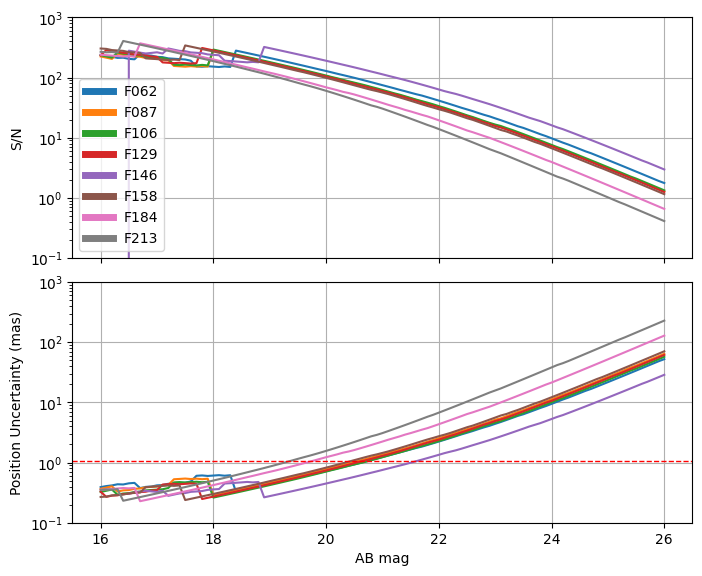

In [6]:
plotdata = pos_err_plots(filts = good_filt_list,
              errfloor = 0.01,
              vega = False,
              factors = good_filt_snr_to_pos_err_factors,
              mag = np.linspace(16, 26, 101, endpoint=True))


In [7]:
datapath = './data/'
if not os.path.isdir(datapath):
    os.mkdir(datapath)

for filt in plotdata:
    out_fname = f'{datapath}roman_{filt.upper()}_pos_errs.csv'
    new_data = { 
        'mags_ab':plotdata[filt]['mags'],
        'pos_errs_mas':plotdata[filt]['pos_errs'],
    }
    pd.DataFrame(new_data).to_csv(out_fname,index=False)
    print(filt.upper(),out_fname)

F062 ./data/roman_F062_pos_errs.csv
F087 ./data/roman_F087_pos_errs.csv
F106 ./data/roman_F106_pos_errs.csv
F129 ./data/roman_F129_pos_errs.csv
F146 ./data/roman_F146_pos_errs.csv
F158 ./data/roman_F158_pos_errs.csv
F184 ./data/roman_F184_pos_errs.csv
F213 ./data/roman_F213_pos_errs.csv
